# Fig: Talk (Redwood-16th)

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.dataset import ROFLDS
from analysis.linear import compute_dci, mi_analysis
from figures.dci import plot_scatter
from figures.mi import plot_hm

from analysis.latent import traverse
from utils.animation import animate_opticflow

from analysis.opticflow import ROFL


kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}
pal_model, pal_cat = get_palette()

## Previous figs

In [3]:
category = 'fixate1'
g, select_lbl = prep_rofl(category)

In [4]:
path = pjoin(tmp_dir, 'trainer_analysis')
fits = [
    'fixate1_nf-420_beta-0.15_(2023_04_27,20:20).npy',
    'vanilla_fixate1_nf-420_beta-1.5_(2023_05_14,14:16).npy',
]
everything = {}
for fit in fits:
    everything[fit] = np.load(
        pjoin(path, fit),
        allow_pickle=True,
    ).item()

### Untang (scatter plot)

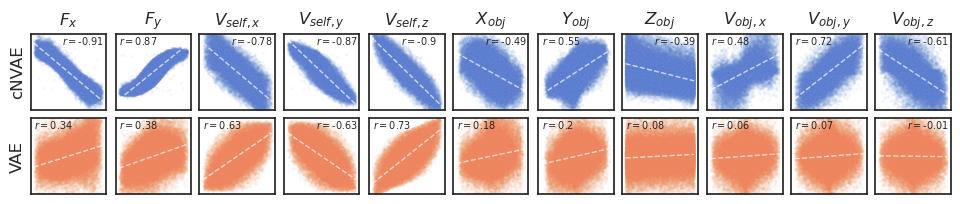

In [5]:
fig, _ = plot_scatter(everything)

In [6]:
for dpi in [600, 300]:
    kws_fig['dpi'] = dpi
    fig.savefig(pjoin(fig_base_dir, f'untang_dpi{dpi}.png'), **kws_fig)

### MI (heatmap)

In [7]:
%%time

mi = {}
for fit, v in everything.items():
    mi[fit] = mi_analysis(v['data_vld']['z'], g['vld'])
data = {
    extract_info(k)[-1]: v['mi']
    for k, v in mi.items()
}

CPU times: user 24.5 s, sys: 19.6 s, total: 44.2 s
Wall time: 5min 57s


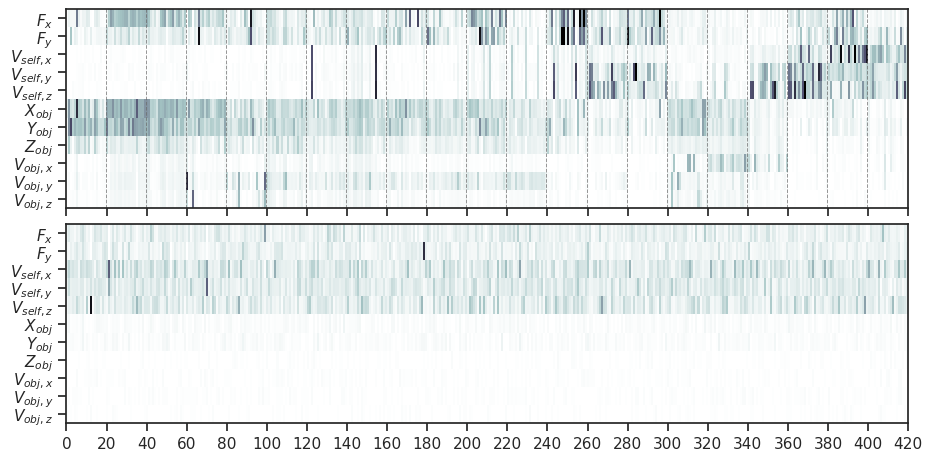

In [8]:
fig, _ = plot_hm(data)

In [9]:
fig.savefig(pjoin(fig_base_dir, 'mi.pdf'), **kws_fig)

## Load trainers

In [3]:
tr = {
    'cNVAE': 'fixate1_nf-420_beta-0.15_(2023_04_27,20:20)',
    'VAE': 'vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15)',
}
tr = {
    k: load_model_lite(
        pjoin(results_dir(), v, 'Trainer'),
        shuffle=False,
        strict=False,
        device='cpu',
    )[0] for k, v in tr.items()
}

### Recon. plot

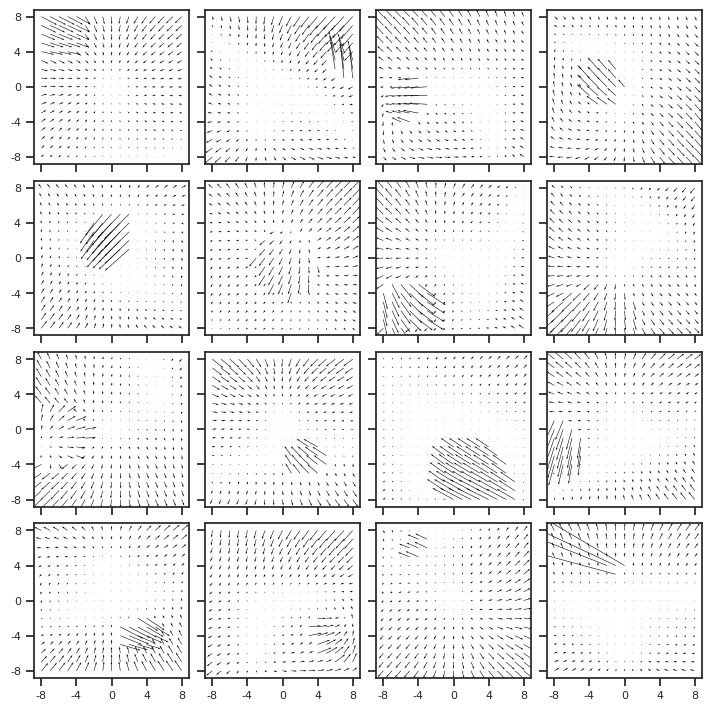

In [4]:
x = tr['cNVAE'].dl_trn.dataset.x[:tr['cNVAE'].cfg.batch_size]
show_opticflow(x);

In [5]:
with torch.no_grad():
    x_hat = {
        k: v.model(x)[0] for
        k, v in tr.items()
    }

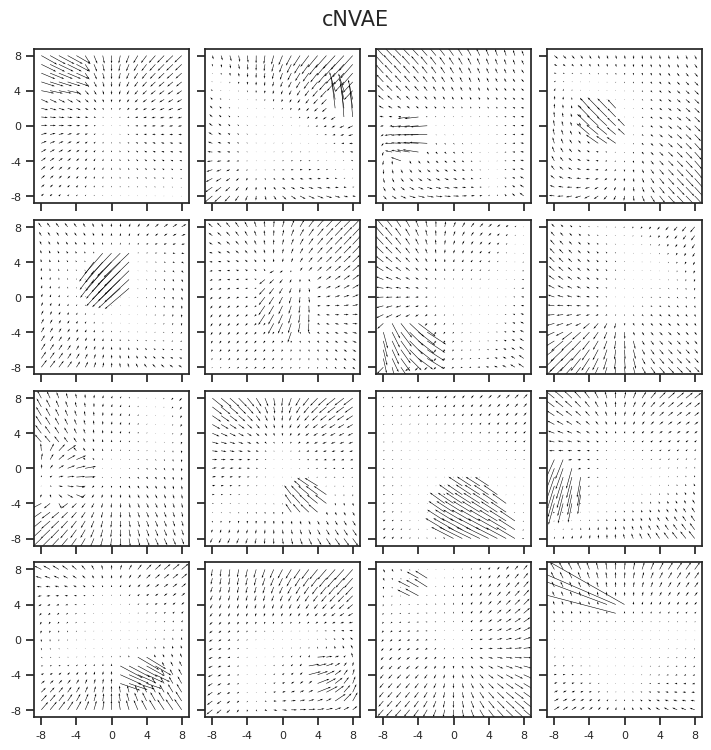

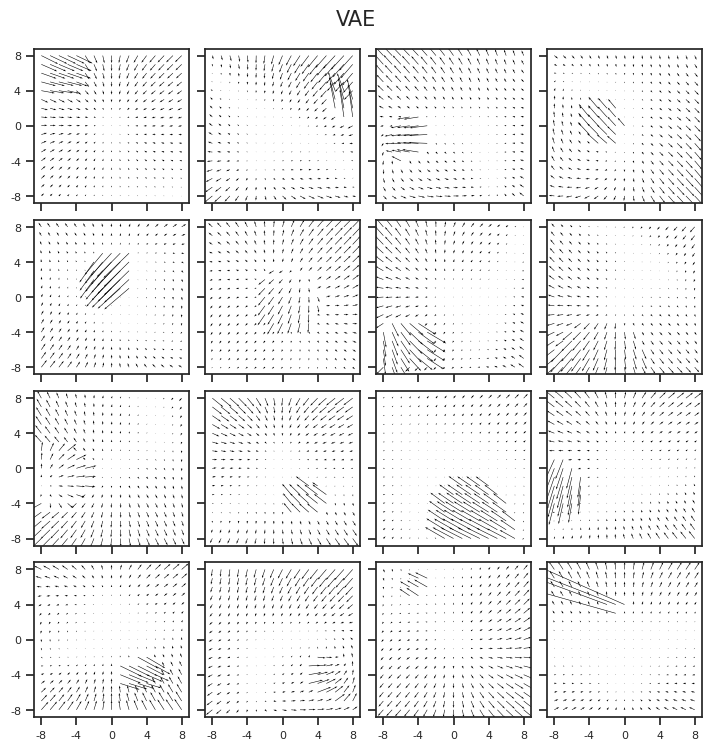

In [6]:
for k, v in x_hat.items():
    fig, _ = show_opticflow(v, display=False);
    fig.suptitle(k, y=1.05, fontsize=15)
    display(fig)

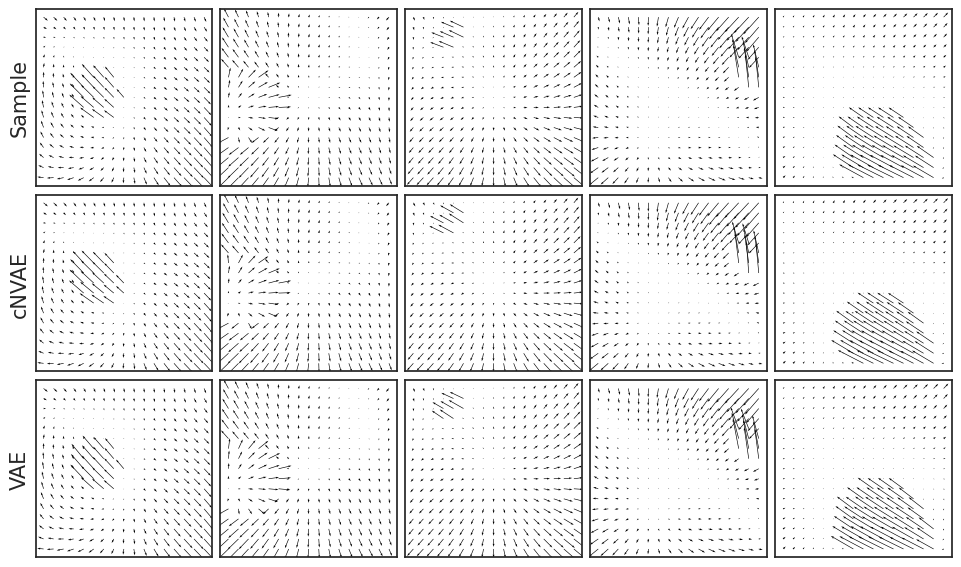

In [7]:
ids = [3, 8, 14, 1, 10]
x2p = torch.stack((
    x[ids],
    x_hat['cNVAE'][ids],
    x_hat['VAE'][ids],
))
fig, axes = show_opticflow_row(x2p, figsize=(9.5, 5.57), display=False)
axes[0, 0].set_ylabel('Sample', fontsize=15)
axes[1, 0].set_ylabel('cNVAE', fontsize=15)
axes[2, 0].set_ylabel('VAE', fontsize=15)
display(fig)

In [8]:
fig.savefig(pjoin(fig_base_dir, 'recon.pdf'), **kws_fig)

### z-Traverse

In [4]:
x = tr['cNVAE'].dl_trn.dataset.x[:tr['cNVAE'].cfg.batch_size]
z, *_ = tr['cNVAE'].model.xtract_ftr(x)

In [5]:
%%time

x_gen = traverse(
    z=z,
    steps=50,
    vae=tr['cNVAE'].model,
    group_i=0,
    latent_i=2,
    mu=0.1701,
    sd=0.4481,
    n_sd=6,
)
x_gen.shape

CPU times: user 15min 1s, sys: 450 ms, total: 15min 2s
Wall time: 34.7 s


(600, 50, 2, 17, 17)

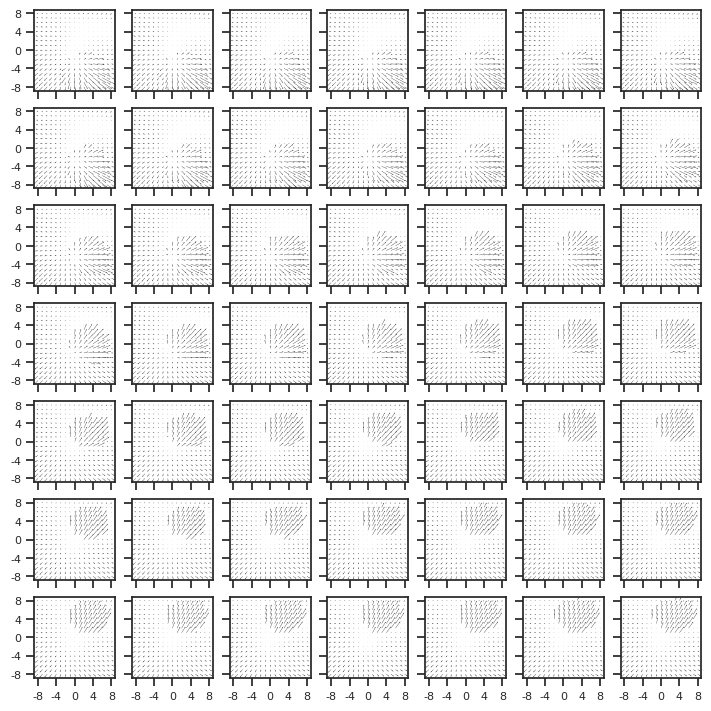

In [6]:
sample_i = 117
show_opticflow(x_gen[sample_i], 7);

In [7]:
inds = [
    3, 5, 31, 45, 53, 117,
    118, 187, 197, 236, 424,
]
x2a = x_gen[inds]
save_file = pjoin(fig_base_dir, 'anim', 'test.mp4')
_ = animate_opticflow(x2a, save_file, nrows=3)

In [8]:
for i in inds:
    save_file = pjoin(fig_base_dir, 'anim', f'sample_{i}.mp4')
    ani, writer = animate_opticflow(
        x=x_gen[[i]][:, :45],
        save_file=save_file,
        title=f'sample_{i}',
    )

In [9]:
inds = [187, 117, 3]
title = f'samples_{inds}'.replace(' ', '')
save_file = pjoin(fig_base_dir, 'anim', f"{title}.mp4")
ani, writer = animate_opticflow(
    x=x_gen[inds][:, :45],
    save_file=save_file,
    title=title,
)

In [10]:
x2p = x_gen[inds][:, :45]
n, frames, _, _, d = x2p.shape
d, odd = x.shape[-2] // 2, x.shape[-2] % 2
span = range(-d, d + 1) if odd else range(-d, d)

for idx, i in enumerate(inds):
    fig, ax = create_figure(1, 1, (2.4, 2.4))
    u, v = x2p[idx, 0, 0, ...], x2p[idx, 0, 1, ...]
    vel = ax.quiver(
        span, span, u, v,
        scale=None,
    )
    remove_ticks(ax, False)
    ax_square(ax)
    plt.close()
    
    save_file = pjoin(fig_base_dir, 'anim', f'sample_{i}.pdf')
    fig.savefig(save_file, **kws_fig)

## g-Traversal

In [3]:
kws = dict(
    category='fixate',
    n_obj=1,
    dim=17,
    fov=45.0,
    obj_r=0.25,
    obj_bound=0.97,
    obj_zlim=(0.5, 1.0),
    vlim_obj=(0.01, 1.0),
    vlim_slf=(0.01, 1.0),
    residual=False,
    z_bg=1.0,
    seed=0,
)
print(kws)

min_obj_size = 3.5

{
    'category': 'fixate',
    'n_obj': 1,
    'dim': 17,
    'fov': 45.0,
    'obj_r': 0.25,
    'obj_bound': 0.97,
    'obj_zlim': (0.5, 1.0),
    'vlim_obj': (0.01, 1.0),
    'vlim_slf': (0.01, 1.0),
    'residual': False,
    'z_bg': 1.0,
    'seed': 0
}

### Just obj, no self motion

In [4]:
n = 17
rofl = ROFL(n=n, **kws).compute_coords()

In [5]:
attrs_slf = {
    'fix': np.zeros((n, 2)),
    'v_slf': np.zeros((n, 3)),
}

# Obj related
alpha = np.array([0, rofl.span[4]])
alpha = np.repeat(alpha.reshape(1, -1), n, 0)
alpha[:, 0] = rofl.span

v_obj = np.array([0.8, 0.5, 0])
v_obj = np.repeat(v_obj.reshape(1, -1), n, 0)

attrs_obj = {0: {
    'alpha': alpha,
    'v_obj': v_obj,
    'z': np.ones(n) * 0.55,
}}
rofl.setattrs(attrs_slf, attrs_obj)
_ = rofl.compute_flow()

In [6]:
scale = 20

In [7]:
save_file = pjoin(fig_base_dir, 'anim', 'objx.mp4')
ani, writer = animate_opticflow(
    x=rofl.alpha_dot,
    save_file=save_file,
    title='objx',
    scale=scale,
)

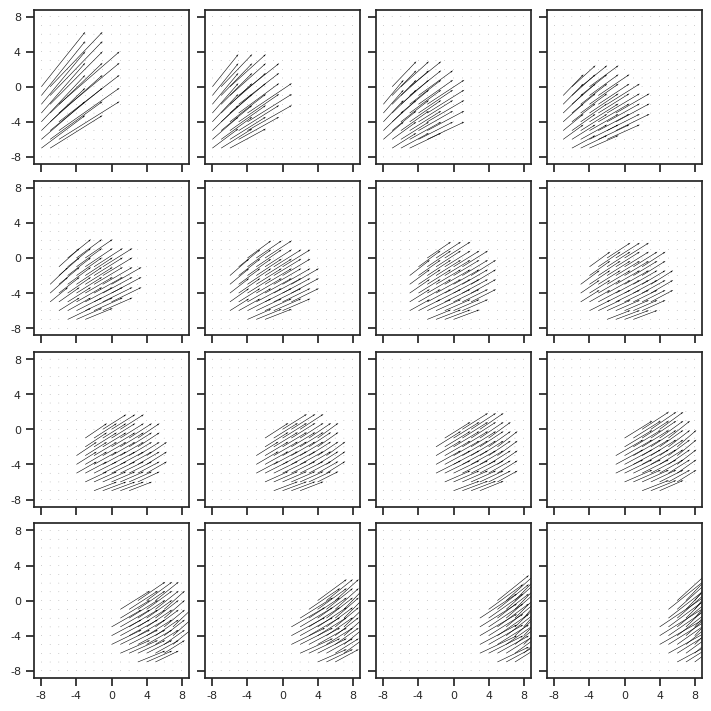

In [8]:
show_opticflow(rofl.alpha_dot);

### add v self

In [9]:
v_slf = np.array([0, 0, 1])
v_slf = np.repeat(v_slf.reshape(1, -1), n, 0)
attrs_slf['v_slf'] = v_slf

rofl2 = ROFL(n=n, **kws).compute_coords()
rofl2.setattrs(attrs_slf, attrs_obj)
_ = rofl2.compute_flow()

In [10]:
scale = 20

In [11]:
save_file = pjoin(fig_base_dir, 'anim', 'objx+vslfz.mp4')
ani, writer = animate_opticflow(
    x=rofl2.alpha_dot,
    save_file=save_file,
    title='objx+vslfz',
    scale=scale,
)

save_file = pjoin(fig_base_dir, 'anim', 'vself_effect.mp4')
ani, writer = animate_opticflow(
    x=np.stack([rofl.alpha_dot, rofl2.alpha_dot]),
    save_file=save_file,
    title='v_self effect',
    scale=scale,
)

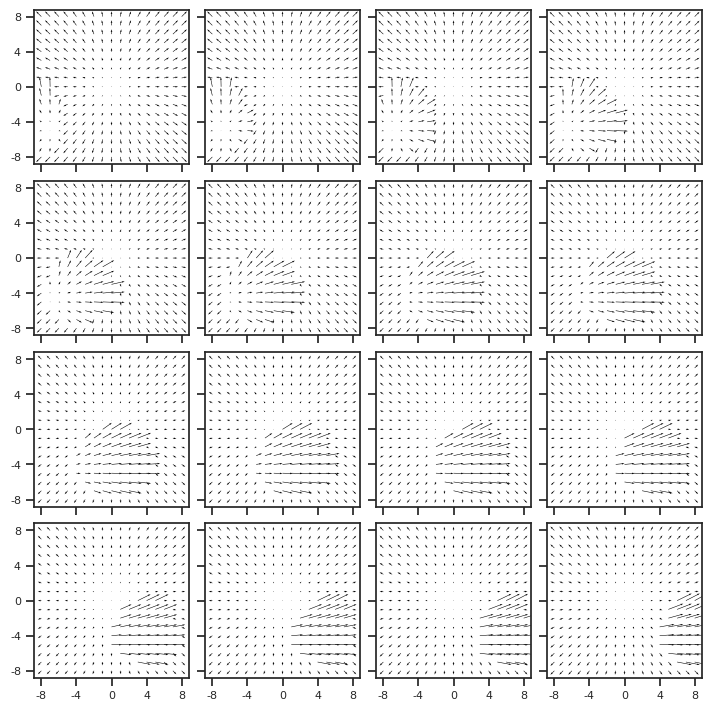

In [12]:
show_opticflow(rofl2.alpha_dot);

### F_x effect

In [13]:
fix = np.zeros((n, 2))
fix[:, 0] = np.linspace(-0.4, 0.4, n)
attrs_slf['fix'] = fix

i = 4
alpha = np.array([rofl.span[i], rofl.span[4]])
alpha = np.repeat(alpha.reshape(1, -1), n, 0)
attrs_obj = {0: {
    'v_obj': v_obj,
    'alpha': alpha,
    'z': np.ones(n) * 0.55,
}}

rofl3 = ROFL(n=n, **kws).compute_coords()
rofl3.setattrs(attrs_slf, attrs_obj)
_ = rofl3.compute_flow()

In [14]:
scale = 15

In [15]:
save_file = pjoin(fig_base_dir, 'anim', 'fixx.mp4')
ani, writer = animate_opticflow(
    x=rofl3.alpha_dot,
    save_file=save_file,
    title='fixx',
    scale=scale,
)

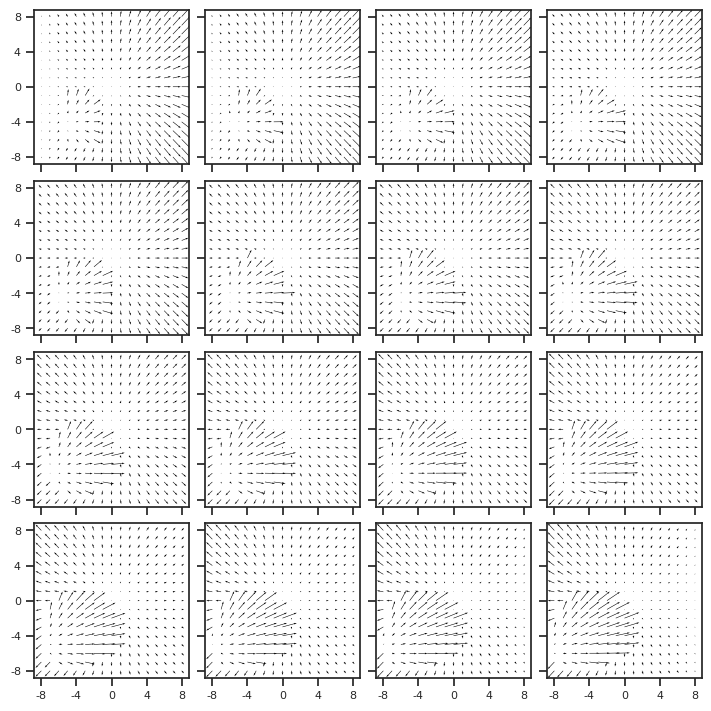

In [16]:
show_opticflow(rofl3.alpha_dot);

### generate single frames

#### Self + Obj

In [59]:
n = 1
rofl = ROFL(n=n, **kws).compute_coords(np.array([0, 0]))

In [60]:
attrs_slf = {
    'fix': np.array([[0, 0]]),
    'v_slf': np.array([[0, 0, 1]]),
}
attrs_obj = {0: {
    'v_obj': np.array([[0.8, 0.5, 0]]),
    'alpha': np.array([[rofl.span[4], rofl.span[4]]]),
    'z': np.ones(n) * 0.55,
}}
rofl.setattrs(attrs_slf, attrs_obj)
_ = rofl.compute_flow()

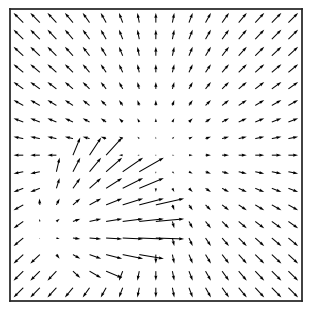

In [61]:
scale = 15

fig, ax = show_opticflow(rofl.alpha_dot, 1, scale=scale, display=False, figsize=(3, 3))
remove_ticks(ax, False)
fig.savefig(pjoin(fig_base_dir, 'motion_self+obj.pdf'), **kws_fig)
display(fig)

#### Obj only

In [62]:
n = 1
rofl = ROFL(n=n, **kws).compute_coords(np.array([0, 0]))

In [63]:
attrs_slf = {
    'fix': np.array([[0, 0]]),
    'v_slf': np.array([[0, 0, 0]]),
}
attrs_obj = {0: {
    'v_obj': np.array([[0.8, 0.5, 0]]),
    'alpha': np.array([[rofl.span[4], rofl.span[4]]]),
    'z': np.ones(n) * 0.55,
}}
rofl.setattrs(attrs_slf, attrs_obj)
_ = rofl.compute_flow()

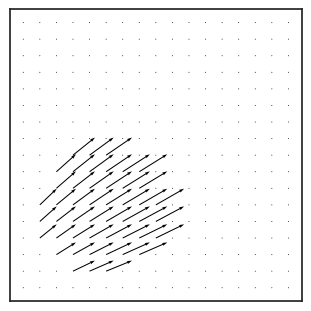

In [64]:
scale = 15

fig, ax = show_opticflow(rofl.alpha_dot, 1, scale=scale, display=False, figsize=(3, 3))
remove_ticks(ax, False)
fig.savefig(pjoin(fig_base_dir, 'motion_obj.pdf'), **kws_fig)
display(fig)

#### Self only

In [67]:
n = 1
kws['n_obj'] = 0
rofl = ROFL(n=n, **kws).compute_coords(np.array([0, 0]))

In [68]:
attrs_slf = {
    'fix': np.array([[0, 0]]),
    'v_slf': np.array([[0, 0, 1]]),
}
rofl.setattrs(attrs_slf)
_ = rofl.compute_flow()

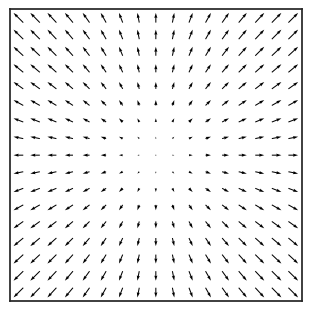

In [69]:
scale = 15

fig, ax = show_opticflow(rofl.alpha_dot, 1, scale=scale, display=False, figsize=(3, 3))
remove_ticks(ax, False)
fig.savefig(pjoin(fig_base_dir, 'motion_self.pdf'), **kws_fig)
display(fig)

#### Sample $5 \times 3 = 15$

In [102]:
n = 9
kws['n_obj'] = 1
kws['seed'] = 108
rofl = ROFL(n=n, **kws).compute_coords()
rofl.compute_flow();

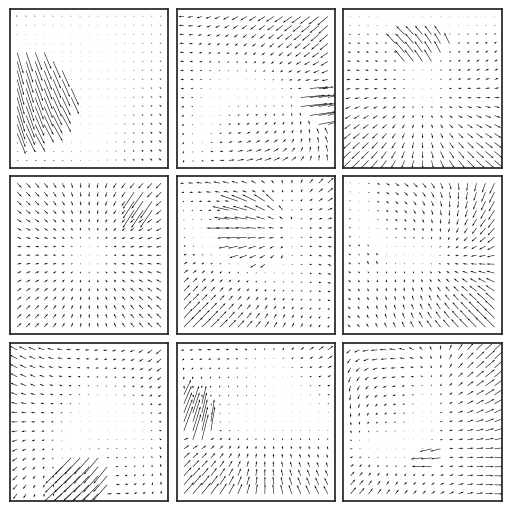

In [103]:
fig, axes = show_opticflow_row(rofl.alpha_dot.reshape(3, 3, 17, 17, 2), figsize=(5, 5))
fig.savefig(pjoin(fig_base_dir, 'rofl_9_samples.pdf'), **kws_fig)

## EPE only plot

In [3]:
from analysis.linear import compute_dci

path = pjoin(tmp_dir, 'trainer_analysis')
skip_fits = [
    'fixate1_nf-420_beta-0.001_(2023_05_16,00/03).npy',
    'fixate1_nf-420_beta-0.8_(2023_05_07,04:15).npy',
]
pal_model, pal_cat = get_palette()

In [4]:
df_dci = collections.defaultdict(list)

for fit in tqdm(sorted(os.listdir(path))):
    if 'reservoir' in fit or fit in skip_fits:
        continue
    if fit in skip_fits:
        continue
    category, nf, beta, tag = extract_info(fit)    
    if beta in [0.001, 20.0]:
        continue
        
    if category != 'fixate1':
        continue

    # load
    everything = np.load(
        pjoin(path, fit),
        allow_pickle=True,
    ).item()
    
    # info
    df_dci['model'].append(tag)
    df_dci['category'].append(category)
    df_dci['beta'].append(beta)
    df_dci['nf'].append(nf)
    
    # losses
    epe = everything['loss']['epe'].mean()
    df_dci['epe'].append(epe)
    df_dci['epepd'].append(epe / 17 ** 2)
    if isinstance(beta, float):
        kl = everything['loss']['kl'].mean()
        tot_active = (everything['loss']['kl_diag'] > 0.1).sum()
    else:
        kl = np.nan
        tot_active = np.nan

    df_dci['nelbo'].append(epe + kl)
    df_dci['kl'].append(kl)
    df_dci['tot_active'].append(tot_active)

df_dci = pd.DataFrame(df_dci)
betas = get_betas(df_dci)

100%|███████████████████████████████████████████| 88/88 [05:14<00:00,  3.57s/it]


In [8]:
_df = df_dci.loc[df_dci['category'] == 'fixate1']
loss = 'epepd'

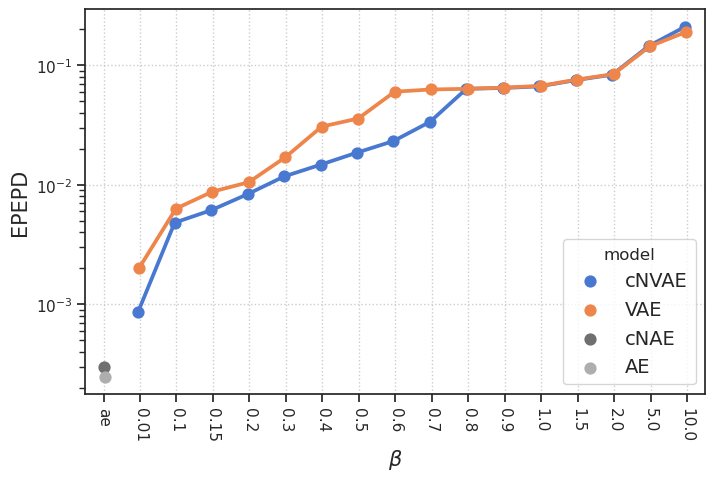

In [10]:
fig, ax = create_figure(1, 1, (8, 5))
sns.pointplot(
    data=_df,
    y=loss,
    x='beta',
    hue='model',
    hue_order=pal_model,
    palette=pal_model,
    order=betas,
    dodge=True,
    ax=ax,
)
ax.set_ylabel(loss.upper(), fontsize=15)
ax.set_xlabel(r'$\beta$', fontsize=15)
ax.tick_params(axis='x', rotation=-90)
sns.move_legend(ax, 'lower right', fontsize=14)
ax.set_yscale('log')
ax.grid()
plt.show()

In [11]:
fig.savefig(pjoin(fig_base_dir, 'epepd.pdf'), **kws_fig)